# <font color="#5fa8d3"> Yolo model


## <font color="#62b6cb"> Table of Content <a name="ToC"></a>
0. [Libraries Importation, Parameters & Funtions Definition](#id0)<br>
1. [Preparation of the data](#id1)<br>
    1.1 [Copy Images to Yolo Folder](#id11)<br>
    1.2 [Obtain the labels for YOLO](#id12)<br>
2. [Yolo Model Training in Sagemaker](#id2)<br>
3. [Yolo Model Training Locally](#id3)<br>

## <font color="#62b6cb"> 0. Libraries Importation, Parameters & Funtions Definition <a name="id0"></a>

In [23]:
# things to put in the config
'./Notebooks/data.yaml'

'./Notebooks/data.yaml'

In [1]:
import json
import os
from ultralytics import YOLO
import shutil
import yaml # for importing a yaml file
import joblib
import torch
import subprocess


import boto3
import tarfile
import joblib
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from io import StringIO
from sagemaker import image_uris

from sagemaker.estimator import Estimator
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, IntegerParameter, HyperparameterTuner, HyperbandStrategyConfig, StrategyConfig

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
current_directory = os.getcwd()
last_folder = os.path.basename(current_directory)
    
if last_folder != "project-danielteresa":
    while last_folder != "project-danielteresa":
        parent_directory = os.path.dirname(current_directory)
        last_folder = os.path.basename(parent_directory)

        os.chdir(parent_directory)
        print(f"Changed directory to: {parent_directory}")
else:
    print("Already in the project root directory.")

# our modules
from src.mymodule import * # for importing our functions

Changed directory to: /home/sagemaker-user/project-danielteresa


**Configuration Variables**

In [22]:
# Load the YAML file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Function to set variables globally and store their names
def set_variables(config, prefix='', var_dict={}):
    for key, value in config.items():
        if isinstance(value, dict):
            set_variables(value, prefix + key + '_', var_dict)
        else:
            globals()[prefix + key] = value
            var_dict[prefix + key] = value
    return var_dict

# Set variables globally and get a dictionary of the set variables
set_vars = set_variables(config)

# Print all the variables that were set
print("Variables set from YAML file:")
for var_name, var_value in set_vars.items():
    print(f"{var_name}: {var_value}")

Variables set from YAML file:
seed: 123
color1: #62b6cb
color2: #fb8500
color3: #023047
color4: #FFB703
path_annotations: ./Data
path_train: ./Data/train/original
path_train_train: ./Data/train/train
path_train_aug: ./Data/train/train_aug
path_train_val: ./Data/train/val
path_test: ./Data/test
path_yolo: ./Data/Yoloimages/
path_models: ./Models
kaggle_train_annotations: annotations_train.json
train_annotations_name_temp: annotations_train_temp.json
train_annotations_name: annotations_train_updated.json
aug_train_annotations_name: annotations_train_updated_aug.json
val_annotations_name: annotations_val_updated.json
kaggle_test_annotations: annotations_test.json
test_annotations_name_temp: annotations_test_temp.json
test_annotations_name: annotations_test_updated.json
weights_yolo_path: Models/yolo_weights
runs_path: Models/runs


## <font color="#62b6cb"> 1. Preparation of data <a name="id1"></a>

### <font color="#62b6cb"> 1.1 Copy Images to Yolo Folder  <a name="id11"></a> 

In [4]:
# Create the folders if they don't exist
directories = [
    os.path.join(path_yolo, "train/images"),
    os.path.join(path_yolo, "train/labels"),
    os.path.join(path_yolo, "val/images"),
    os.path.join(path_yolo, "val/labels"),
    os.path.join(path_yolo, "test/images"),
    os.path.join(path_yolo, "test/labels")
]

for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Remove everything that exists in the folders
for directory in [    os.path.join(path_yolo, "train/images"),
                      os.path.join(path_yolo, "train/labels"),
                      os.path.join(path_yolo, "val/images"),
                      os.path.join(path_yolo, "val/labels"),
                      os.path.join(path_yolo, "test/images"),
                      os.path.join(path_yolo, "test/labels")]:
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove the directory and its contents
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

# Copy images from train augmented to Yolo train folder
shutil.copytree(path_train_aug, os.path.join(path_yolo, "train/images"), dirs_exist_ok=True)
shutil.copytree(path_train_val, os.path.join(path_yolo, "val/images"), dirs_exist_ok=True)
shutil.copytree(path_test, os.path.join(path_yolo, "test/images"), dirs_exist_ok=True)

print("Folders have been cleaned and files have been copied successfully.")

Folders have been cleaned and files have been copied successfully.


Check the annotations and id of the coco jsons

In [5]:
print("Check that annotation for training is correct")
print(validate_coco_dataset(os.path.join(path_annotations,aug_train_annotations_name), os.path.join(path_yolo,"train/images")))

print("Check that annotation for validation is correct")
print(validate_coco_dataset(os.path.join(path_annotations,val_annotations_name), os.path.join(path_yolo,"val/images")))

print("Check that annotation for test is correct")
print(validate_coco_dataset(os.path.join(path_annotations,test_annotations_name), os.path.join(path_yolo,"test/images")))

Check that annotation for training is correct
True
Check that annotation for validation is correct
True
Check that annotation for test is correct
True


Some of the points of the polygons are out of the range of the width and the height

In [6]:
# Some of the points of the polygons are out of the range of the images

# train
process_coco_annotations(os.path.join(path_annotations,aug_train_annotations_name),
                          os.path.join(path_annotations,aug_train_annotations_name))

# val
process_coco_annotations(os.path.join(os.path.join(path_annotations,val_annotations_name)), 
                         os.path.join(os.path.join(path_annotations,val_annotations_name)) )

In [8]:
with open(os.path.join(path_annotations, train_annotations_name), 'r') as f:
    coco_data = json.load(f)

# Extract image sizes
widths = []
heights = []

for image in coco_data['images']:
    widths.append(image['width'])
    heights.append(image['height'])

# Find the range of widths and heights
min_width = min(widths)
max_width = max(widths)
min_height = min(heights)
max_height = max(heights)

print(f"Width range: {min_width} to {max_width}")
print(f"Height range: {min_height} to {max_height}")

Width range: 204 to 2365
Height range: 153 to 2560


### <font color="#62b6cb"> 1.2 Obtain the labels for YOLO  <a name="id12"></a> 

Obtain the yolo txt for each images from the coco data annotations using the conver_coco from ultralytics. The annotations json to convert should be in a folder with that json in it.

In [7]:
# Obtain the yolo labels
# train
convert_coco_to_yolo_segmentation(path_annotations, aug_train_annotations_name, path_yolo, 'train')
# val
convert_coco_to_yolo_segmentation(path_annotations, val_annotations_name, path_yolo, 'val')
# test
convert_coco_to_yolo_segmentation(path_annotations, test_annotations_name, path_yolo, 'test')

Annotations /home/sagemaker-user/project-danielteresa/Data/Yoloimages/train/annotations_train_updated_aug.json: 100%|██████████| 46485/46485 [00:21<00:00, 2120.37it/s]

COCO data converted successfully.
Results saved to /home/sagemaker-user/project-danielteresa/Data/Yoloimages/aux


Removed auxiliary directory ./Data/Yoloimages/aux
Yolo labels saved in ./Data/Yoloimages/train/labels



Annotations /home/sagemaker-user/project-danielteresa/Data/Yoloimages/val/annotations_val_updated.json: 100%|██████████| 2324/2324 [00:00<00:00, 11731.09it/s]

COCO data converted successfully.
Results saved to /home/sagemaker-user/project-danielteresa/Data/Yoloimages/aux


Removed auxiliary directory ./Data/Yoloimages/aux
Yolo labels saved in ./Data/Yoloimages/val/labels



Annotations /home/sagemaker-user/project-danielteresa/Data/Yoloimages/test/annotations_test_updated.json: 100%|██████████| 2324/2324 [00:00<00:00, 12472.27it/s]

COCO data converted successfully.
Results saved to /home/sagemaker-user/project-danielteresa/Data/Yoloimages/aux


Removed auxiliary directory ./Data/Yoloimages/aux
Yolo labels saved in ./Data/Yoloimages/test/labels



We check the nº of elememts in the folder:

In [8]:
# Define the directory path
directory_path = path_yolo+'/train/labels'

# List all files in the directory
files = os.listdir(directory_path)

# Count the number of files
file_count = len([file for file in files if os.path.isfile(os.path.join(directory_path, file))])

print(f"Number of files in '{directory_path}': {file_count}")

Number of files in './Data/Yoloimages//train/labels': 46485


### <font color="#62b6cb"> 2. Yolo Model Training in Sagemaker  <a name="id2"></a> 

We upload the files to S3:

In [13]:
# Define the bucket name and the folder to copy to S3
bucket_train = "sagemaker-eu-west-1-project-danielteresa/train"
local_train = "Data/Yoloimages/train"

bucket_val = "sagemaker-eu-west-1-project-danielteresa/val"
local_val = "Data/Yoloimages/val"

bucket_test = "sagemaker-eu-west-1-project-danielteresa/test"
local_test = "Data/Yoloimages/test"

# Upload train, test and validation folders
upload_folder_to_s3(local_train, bucket_train)
upload_folder_to_s3(local_val, bucket_val)
upload_folder_to_s3(local_test, bucket_test)

Uploading Data/Yoloimages/test: 100%|██████████| 4649/4649 [00:26<00:00, 174.29file/s]


0

Now we upload the annotations the data.yaml file for train the model too:

In [27]:
with open(os.path.join(path_annotations,val_annotations_name), 'r') as f:
    coco_data = json.load(f)

names = [class_name['name'] for class_name in coco_data["categories"]]

# Specify the paths and information

train_path = 'train_prueba/images'
val_path = 'val_prueba/images'

names_categories = [class_name['name'] for class_name in coco_data["categories"]]
nc = len(names)
file_path = './Notebooks/data.yaml'

# Create the YAML file
create_yaml_file(file_path, train_path, val_path, nc, names)

In [28]:
# Define the bucket name and the file to copy to S3
bucket_annotations = "sagemaker-eu-west-1-project-danielteresa"
file_to_upload = "./Notebooks/data.yaml"

# Upload the file to the specified S3 bucket
upload_file_to_s3(file_to_upload, bucket_annotations)

Successfully uploaded ./Notebooks/data.yaml to s3://sagemaker-eu-west-1-project-danielteresa/data.yaml


We already create the prueba images and upload:

In [29]:
# Folder Set up
train_folder = './Data/Yoloimages/train'
val_folder = './Data/Yoloimages/val'

destination_train_folder = './Data/Yoloimages/train_prueba'
destination_val_folder = './Data/Yoloimages/val_prueba'

# Seleccionar 20 imágenes de cada carpeta
select_images(train_folder, destination_train_folder, 20, 'images', 'labels', seed)
select_images(val_folder, destination_val_folder, 20, 'images', 'labels', seed)

In [30]:
# Define the bucket name and the folder to copy to S3
bucket_train = "sagemaker-eu-west-1-project-danielteresa/train_prueba"
local_train = "Data/Yoloimages/train_prueba"

bucket_val = "sagemaker-eu-west-1-project-danielteresa/val_prueba"
local_val = "Data/Yoloimages/val_prueba"


# Upload train, test and validation folders
upload_folder_to_s3(local_train, bucket_train)
upload_folder_to_s3(local_val, bucket_val)

Uploading Data/Yoloimages/val_prueba: 100%|██████████| 40/40 [00:00<00:00, 51.80file/s]


0

We define the credentials to run the trainning job

In [27]:
# Set AWS region

sts_client = boto3.client('sts')

role_arn = 'arn:aws:iam::794367255496:role/daniel.quesada10'  # Replace with your actual role ARN

assumed_role = sts_client.assume_role(
    RoleArn=role_arn,
    RoleSessionName='SageMakerSession'
)

credentials = assumed_role['Credentials']

# Use the assumed role credentials to create a new session
sagemaker_session = sagemaker.Session(
    boto3.Session(
        aws_access_key_id=credentials['AccessKeyId'],
        aws_secret_access_key=credentials['SecretAccessKey'],
        aws_session_token=credentials['SessionToken'],
    )
)

We produce the train py file for running the train job:

In [5]:
%%writefile train.py

import subprocess
import sys

# Install ultralytics
subprocess.check_call([sys.executable, "-m", "pip", "install", "ultralytics"])

import argparse
import sys
import os
import shutil
import torch

from ultralytics import YOLO


if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    # Hyperparameters
    # parser.add_argument("--num_images", type=int, default=50)
    # parser.add_argument("--seed", type=int, default=123)
    
    parser.add_argument('--epochs',type=int, help='number of training epochs')
    parser.add_argument("--batch", type=int, default=5)
    
    parser.add_argument('--optimizer', type=str, help='optimizer to use')
    parser.add_argument('--lr0', type=float, help='initial learning rate')
    parser.add_argument('--lrf', type=float, help='final learning rate')
    parser.add_argument('--momentum', type=float, help='momentum')
    parser.add_argument('--weight_decay', type=float, help='optimizer weight decay')

    # SageMaker specific arguments
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--runs-path", type=str, default=os.environ.get("SM_OUTPUT_DATA_DIR"))

   
    args = parser.parse_args()

    print('---------------Debug injected environment and arguments--------------------')
    print(sys.argv)
    print(os.environ)
    print('---------------End debug----------------------')

  
    # Train the YOLO model
    # yolo_model = YOLO(os.path.join(args.weights_yolo_path, "yolov8m-seg.pt"))
    yolo_model = YOLO("yolov8m-seg.pt")
    yolo_model.train(data=os.path.join(args.train, "data.yaml"), 
                     batch=args.batch,
                     epochs=args.epochs, 
                     optimizer=args.optimizer, 
                     lr0=args.lr0, 
                     lrf=args.lrf, 
                     momentum=args.momentum,
                     weight_decay=args.weight_decay,
                     task='segment',
                     project=args.runs_path)
    
    yolo_model.export()

Overwriting train.py


We finally train in sagemaker:

In [6]:
image_uri = image_uris.retrieve(
    framework='pytorch',
    region='eu-west-1',
    version='1.12.1',
    py_version='py38',
    instance_type='ml.g4dn.xlarge',
    image_scope='training'
)

In [6]:
metric_definitions = [
    {"Name": "precision", "Regex": "YOLO Metric metrics/precision\\(B\\): (.*)"},
    {"Name": "recall", "Regex": "YOLO Metric metrics/recall\\(B\\): (.*)"},
    {"Name": "mAP50", "Regex": "YOLO Metric metrics/mAP50\\(B\\): (.*)"},
    {"Name": "mAP50-95", "Regex": "YOLO Metric metrics/mAP50-95\\(B\\): (.*)"},
    {"Name": "box_loss", "Regex": "YOLO Metric val/box_loss: (.*)"},
    {"Name": "cls_loss", "Regex": "YOLO Metric val/cls_loss: (.*)"},
    {"Name": "dfl_loss", "Regex": "YOLO Metric val/dfl_loss: (.*)"}
]

In [9]:
bucket_name = "sagemaker-eu-west-1-project-danielteresa/"
train_data_path = f's3://{bucket_name}'
output_path = f's3://{bucket_name}/output'

estimator = PyTorch(
    entry_point="train.py",
    role=role_arn,
    image_uri=image_uri, 
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    # instance_type='ml.m5.12xlarge',
    framework_version="1.12.1",
    py_version="py38",
    sagemaker_session=sagemaker_session,
    hyperparameters={
        'epochs': 10,
        'optimizer': 'Adam',
        'lr0': 0.01,
        'lrf': 0.01,
        'momentum': 0.937,
        'weight_decay': 0.0005
    },
    use_spot_instances=True,
    # input_mode='File',  # FastFile causes a issue with writing label cache
    debugger_hook_config=False,
    max_wait=360000+3600,
    max_run=360000,
    output_path=output_path,
    enable_sagemaker_metrics=True,
    metric_definitions=metric_definitions,
)
estimator.fit({"train": train_data_path})

INFO:sagemaker:Creating training-job with name: pytorch-training-2024-08-03-08-36-23-343


2024-08-03 08:36:23 Starting - Starting the training job......
2024-08-03 08:37:06 Starting - Preparing the instances for training...
2024-08-03 08:37:27 Downloading - Downloading input data............................................................
2024-08-03 08:47:48 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-08-03 08:47:49,687 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-08-03 08:47:49,689 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-08-03 08:47:49,691 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-08-03 08:47:49,702 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-08-03 08:47:49,705 sagemaker_pytorch_container.training INFO     Invoking user training script.


# Tuning sagemaker


In [17]:
hyperparameter_ranges = {
    'epochs': IntegerParameter(10, 30, scaling_type='Auto'),
    'batch': IntegerParameter(32, 68, scaling_type='Auto'),
    'lr0': ContinuousParameter(1e-5, 1e-1, scaling_type='Auto'),
    'lrf': ContinuousParameter(0.01, 1, scaling_type='Auto'),
    'momentum': ContinuousParameter(0.6, 0.98, scaling_type='Auto'),
    'weight_decay': ContinuousParameter(0.0, 0.001, scaling_type='Auto')
}

image_uri = image_uris.retrieve(
    framework='pytorch',
    region='eu-west-1',
    version='1.12.1',
    py_version='py38',
    instance_type='ml.g4dn.xlarge',
    image_scope='training'
)


metric_definitions = [
    {
        "Name": "box_loss", 
        "Regex": "Epoch\\s+\\d+\\/\\d+\\s+\\d+G\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)"
    },
    {
        "Name": "cls_loss", 
        "Regex": "Epoch\\s+\\d+\\/\\d+\\s+\\d+G\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)"
    },
    {
        "Name": "dfl_loss", 
        "Regex": "Epoch\\s+\\d+\\/\\d+\\s+\\d+G\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)"
    },
    {
        "Name": "mAP50", 
        "Regex": "all\\s+\\d+\\s+\\d+\\s+\\d+\\.\\d+\\s+\\d+\\.\\d+\\s+(\\d+\\.\\d+)\\s+\\d+\\.\\d+"
    },
    {
        "Name": "mAP50-95", 
        "Regex": "all\\s+\\d+\\s+\\d+\\s+\\d+\\.\\d+\\s+\\d+\\.\\d+\\s+\\d+\\.\\d+\\s+(\\d+\\.\\d+)"
    }
]



cos_lr = True

conf	0.5
iou   0.5

In [18]:
%%writefile train_tune.py

import subprocess
import sys

# Install ultralytics
subprocess.check_call([sys.executable, "-m", "pip", "install", "ultralytics"])

import argparse
import sys
import os
import shutil
import torch

from ultralytics import YOLO


if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    # Hyperparameters
    
    parser.add_argument('--epochs',type=int, help='number of training epochs')
    parser.add_argument("--batch", type=int, default=5)
    
    parser.add_argument('--optimizer', type=str, help='optimizer to use')
    parser.add_argument('--lr0', type=float, help='initial learning rate')
    parser.add_argument('--lrf', type=float, help='final learning rate')
    parser.add_argument('--momentum', type=float, help='momentum')
    parser.add_argument('--weight_decay', type=float, help='optimizer weight decay')

    # SageMaker specific arguments
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--runs-path", type=str, default=os.environ.get("SM_OUTPUT_DATA_DIR"))

   
    args = parser.parse_args()

    print('---------------Debug injected environment and arguments--------------------')
    print(sys.argv)
    print(os.environ)
    print('---------------End debug----------------------')

  
    # Train the YOLO model
    # yolo_model = YOLO(os.path.join(args.weights_yolo_path, "yolov8m-seg.pt"))
    yolo_model = YOLO("yolov8m-seg.pt")
    yolo_model.train(data=os.path.join(args.train, "data.yaml"), 
                     batch=args.batch,
                     epochs=args.epochs, 
                     optimizer=args.optimizer, 
                     lr0=args.lr0, 
                     lrf=args.lrf, 
                     momentum=args.momentum,
                     weight_decay=args.weight_decay,
                     task='segment',
                     project=args.runs_path)
    
    yolo_model.export()

Overwriting train_tune.py


In [19]:
# Estimator
bucket_name = "sagemaker-eu-west-1-project-danielteresa/"
train_data_path = f's3://{bucket_name}'
output_path = f's3://{bucket_name}/output'

estimator_tune = PyTorch(
    entry_point="train_tune.py",
    role=role_arn,
    image_uri=image_uri, 
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    # instance_type='ml.m5.12xlarge',
    framework_version="1.12.1",
    py_version="py38",
    sagemaker_session=sagemaker_session,
    hyperparameters={
        'optimizer': 'Adam',
    },
    use_spot_instances=True,
    # input_mode='File',  # FastFile causes a issue with writing label cache
    debugger_hook_config=False,
    max_wait=360000+3600,
    max_run=360000,
    output_path=output_path,
    enable_sagemaker_metrics=True,
    metric_definitions=metric_definitions,
)



In [22]:
tuner = HyperparameterTuner(estimator_tune, 
                            objective_metric_name="mAP50-95", 
                            metric_definitions=metric_definitions, 
                            hyperparameter_ranges= hyperparameter_ranges, 
                            #strategy='Hyperband',
                            strategy='Random', 
                            max_jobs=2,  # Only one job needed since hyperparameters are constant
                            max_parallel_jobs=1  # Only one job needed since hyperparameters are constant
                            # strategy_config = StrategyConfig(hyperband_strategy_config=HyperbandStrategyConfig(max_resource=10, min_resource = 1))
                           )
tuner.fit({"train": train_data_path}, job_name="pytorch-training-240803-1623")

#  ^[a-zA-Z0-9](-*[a-zA-Z0-9]){0,31}

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ClientError: An error occurred (ExpiredTokenException) when calling the DescribeHyperParameterTuningJob operation: The security token included in the request is expired

Obtain the models trained by the tuner and the metrics of the model. The YOLO model selects the best weights through the epochs by defining the metric `best_metric = mAP50 * 0.9 + mAP50-95 * 0.1`. For more information on how this metric is defined and used to choose the best weights, please check this [link to the explanation](https://github.com/ultralytics/ultralytics/issues/3972).


In [5]:
bucket_name = "sagemaker-eu-west-1-project-danielteresa/"
bucket_name2 = bucket_name[:-1]
name_tuning = "pytorch-training-240803-1623"

In [6]:
from sagemaker.tuner import HyperparameterTuningJobAnalytics
import tarfile
import pandas as pd
from io import BytesIO
import boto3


s3 = boto3.client('s3')

# Retrieve training job names from the dataframe
tuner_analytics = HyperparameterTuningJobAnalytics(name_tuning)
results_df = tuner_analytics.dataframe()
training_job_names = results_df["TrainingJobName"].tolist()

# Create a dictionary to store the paths of the .tar.gz files
output_targz_dict = {
    job_name: file['Key']
    for file in s3.list_objects_v2(Bucket=bucket_name2).get("Contents", [])
    for job_name in training_job_names
    if job_name in file['Key']
}


results_df.set_index('TrainingJobName', inplace=True)

# Process each .tar.gz file and update the dataframe
for job_name, tar_gz_file in output_targz_dict.items():
    response = s3.get_object(Bucket=bucket_name2, Key=tar_gz_file)
    tar_gz_data = response['Body'].read()

    with tarfile.open(fileobj=BytesIO(tar_gz_data), mode='r:gz') as tar:
        # Look for the 'train/results.csv' file inside the .tar.gz
        csv_file = tar.extractfile('train/results.csv')
        if csv_file:
            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(csv_file)
            df.columns = df.columns.str.strip()

            # Calculate the combined metric
            df['combined_metric'] = df['metrics/mAP50(M)'] * 0.9 + df['metrics/mAP50-95(M)'] * 0.1
            best_epoch = df.loc[df['combined_metric'].idxmax()]['epoch']
            results_df.loc[job_name, "FinalObjectiveValue"] = df['combined_metric'].max()
            
        else:
            print(f"'train/results.csv' not found in {tar_gz_file}")



In [27]:
results_df = results_df.sort_values(by='FinalObjectiveValue', ascending=False)
pd.DataFrame(results_df.iloc[0])

,pytorch-training-240803-1623-001-e94cea16
batch,32.0
epochs,24.0
lr0,0.000731
lrf,0.315215
momentum,0.821607
weight_decay,0.00008
TrainingJobStatus,Completed
FinalObjectiveValue,0.042237
TrainingStartTime,2024-08-03 16:24:30+00:00
TrainingEndTime,2024-08-03 16:47:45+00:00


In [25]:
best_jobname = results_df.index[0]
targz_bestmodel = output_targz_dict[best_jobname]
path_bestmodel = os.path.join(path_models, 'best_modeltuning')

if os.path.exists(path_bestmodel):
    shutil.rmtree(path_bestmodel)
    os.makedirs(path_bestmodel)
else:
    os.makedirs(path_bestmodel)
    
# Download the .tar.gz file from S3
response = s3.get_object(Bucket=bucket_name2, Key=targz_bestmodel)
tar_gz_data = response['Body'].read()
with tarfile.open(fileobj=BytesIO(tar_gz_data), mode='r:gz') as tar:
    tar.extractall(path=path_bestmodel)

print(f"The model has been extracted to {path_bestmodel}")


The model has been extracted to ./Models/best_modeltuning


In [81]:
# Validation metrics
tuning_model = YOLO(os.path.join(path_bestmodel, 'train/weights/best.pt'))

# Download the val folder from S3
s3_resource = boto3.resource('s3')
bucket = s3_resource.Bucket(bucket_name2)
for obj in bucket.objects.filter(Prefix = 'val_prueba'): 
        if not os.path.exists(os.path.dirname(obj.key)):
            os.makedirs(os.path.dirname(obj.key))
        bucket.download_file(obj.key, os.path.join(obj.key)) # save to same path

In [97]:
#create a yaml for the tuning model 

with open(os.path.join(path_annotations,val_annotations_name), 'r') as f:
    coco_data = json.load(f)

names = [class_name['name'] for class_name in coco_data["categories"]]

# Specify the paths and information
train_path = os.path.join(os.getcwd(), 'train_prueba/images')
val_path = os.path.join(os.getcwd(), 'val_prueba/images')

names_categories = [class_name['name'] for class_name in coco_data["categories"]]
nc = len(names)
path_yaml_tune = './Notebooks/data_tune.yaml'

create_yaml_file(path_yaml_tune, train_path, val_path, nc, names)




In [107]:
metrics = tuning_model.val(data = path_yaml_tune, project =  os.path.join(os.getcwd(), 'Models/best_modeltuning'))

Ultralytics YOLOv8.2.73 🚀 Python-3.10.14 torch-2.0.0.post104 CPU (Intel Xeon Platinum 8488C)


val: Scanning /home/sagemaker-user/project-danielteresa/val_prueba/labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


                   all         20         54    0.00914     0.0934      0.054     0.0331      0.587     0.0101      0.045     0.0172
              mis_lost          7         11     0.0323     0.0909       0.11      0.011       0.28     0.0909       0.11      0.011
              met_tear          3          6          0          0          0          0          1          0          0          0
           met_scratch          6         19          0          0          0          0          0          0          0          0
           glass_crack          4          4       0.05       0.75      0.377      0.287          1          0      0.295      0.144
             mis_punct          1          1          0          0          0          0          1          0          0          0
              mis_lamp          1          1          0          0          0          0          0          0          0          0
        met_dent_minor          4          5          0          0   

,Class Name,Box mAP50,Segmentation mAP50,Box Precision,Segmentation Precision,Box Recall,Segmentation Recall,Box F1 Score,Segmentation F1 Score
0,mis_lost,0.0110,0.0110,0.0323,0.2795,0.0909,0.0909,0.0476,0.1372
1,met_tear,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
2,met_scratch,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,glass_crack,0.2870,0.1437,0.0500,1.0000,0.7500,0.0000,0.0938,0.0000
4,mis_punct,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
5,mis_lamp,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,met_dent_minor,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
7,met_dent_medium,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
8,met_dent_severe,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


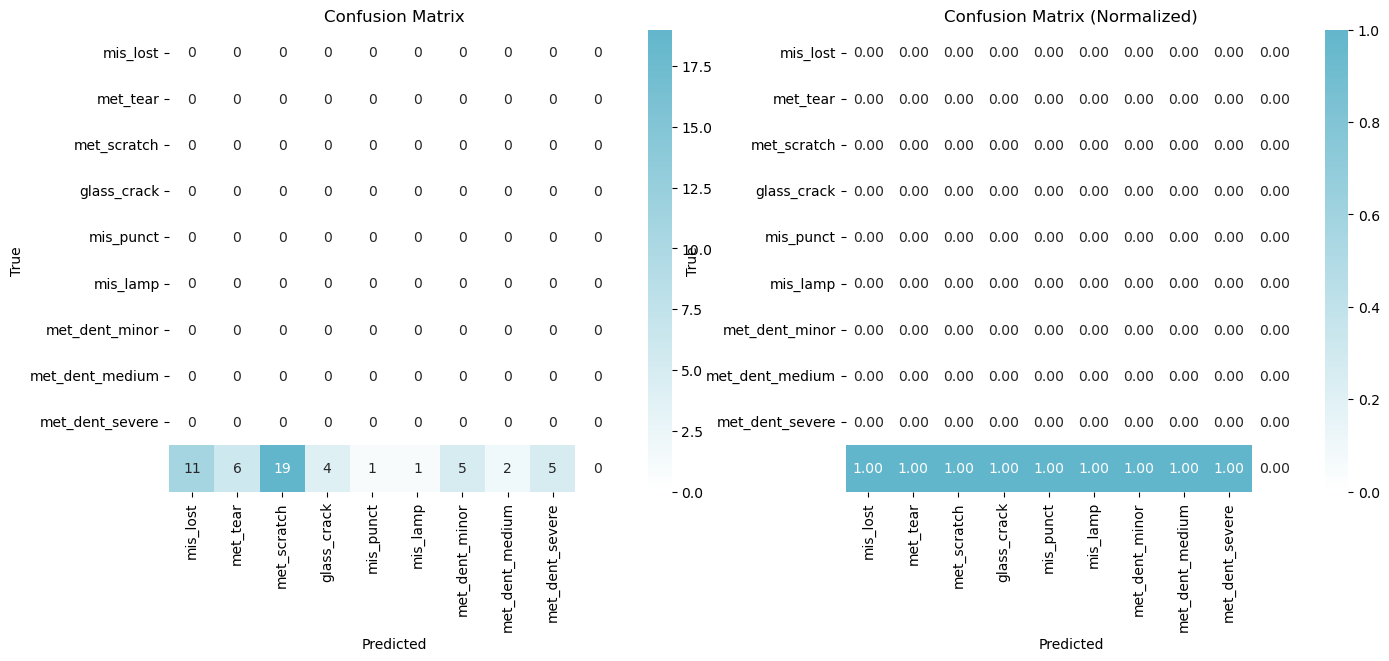

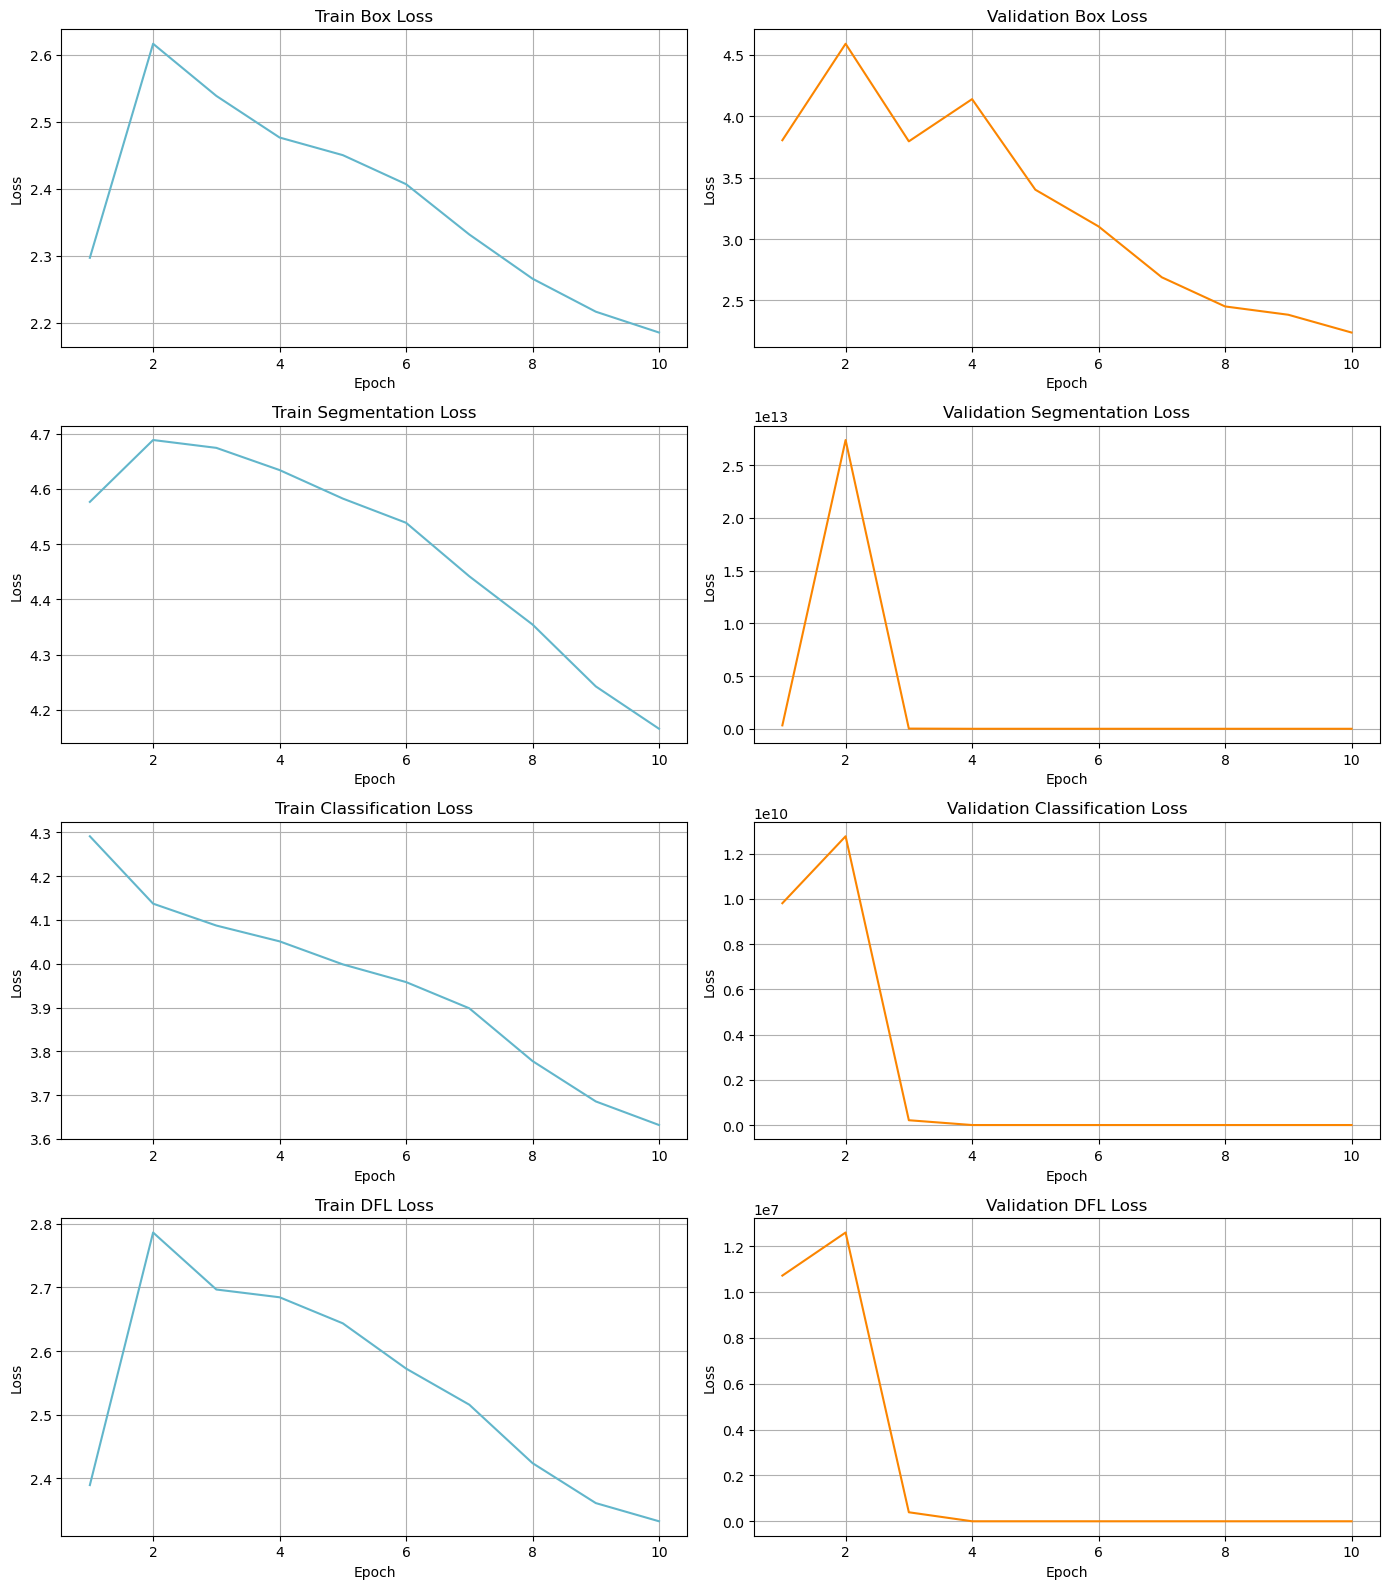

In [106]:
%matplotlib inline
# Validate the model
metrics_yolo(model = tuning_model,path_results_yolo = os.path.join(path_bestmodel, 'train'), color1 = color1, color2 = color2)

FALTA CODIGO PARA ELIMINARLA CARPETA VAL 
VER SI ESTAN BIEN METRICAS 
CHEQUEAR TODO

### <font color="#62b6cb"> 3. Yolo Model Training Locally  <a name="id3></a> 

We define a subset of images

In [34]:
# Folder Set up
train_folder = './Data/Yoloimages/train'
val_folder = './Data/Yoloimages/val'

destination_train_folder = './Data/Yoloimages/train_prueba'
destination_val_folder = './Data/Yoloimages/val_prueba'

# Seleccionar 20 imágenes de cada carpeta
select_images(train_folder, destination_train_folder, 20, 'images', 'labels', seed)
select_images(val_folder, destination_val_folder, 20, 'images', 'labels', seed)

The yaml file is created for the yolo code.

In [33]:
with open(os.path.join(path_annotations,val_annotations_name), 'r') as f:
    coco_data = json.load(f)

names = [class_name['name'] for class_name in coco_data["categories"]]

# Specify the paths and information
actual_path = os.getcwd()
train_path = os.path.join(actual_path, 'Data/Yoloimages/train_prueba/images')
val_path = os.path.join(actual_path, 'Data/Yoloimages/val_prueba/images')

names_categories = [class_name['name'] for class_name in coco_data["categories"]]
nc = len(names)
file_path = './Notebooks/data.yaml'

# Create the YAML file
create_yaml_file(file_path, train_path, val_path, nc, names)

We train the model or uploaded if it was already trained:

In [ ]:
# Path to save/load the model
model_path = "./Models/yolo_model.pkl"

# Fit the GLM with Gamma family and log link if it is not saved
if os.path.exists(model_path):
    print("Loading existing model...")
    yolo_model = joblib.load(model_path)
else:
    print("Training new model...")
    try:
        if not os.path.exists(weights_yolo_path):
            os.makedirs(weights_yolo_path)
        # Initialize the YOLO model with the specified weights
        yolo_model = YOLO(os.path.join(weights_yolo_path, "yolov8m-seg.pt"))
        
        # Train the YOLO model
        yolo_model.train(data="./Notebooks/data.yaml", 
                         batch=100,
                         epochs=10, 
                         optimizer='Adam', 
                         task='segment',
                         project=runs_path)
        # Save the model
        joblib.dump(yolo_model, model_path)
        print(f"Model saved to {model_path}")
    except Exception as e:
        print("Error fitting the model:", e)
        raise e

Training new model...


100%|██████████| 52.4M/52.4M [00:00<00:00, 83.4MB/s]


Ultralytics YOLOv8.2.70 🚀 Python-3.10.14 torch-2.0.0.post104 CPU (Intel Xeon Platinum 8488C)
engine/trainer: task=segment, mode=train, model=Models/yolo_weights/yolov8m-seg.pt, data=./Notebooks/data.yaml, epochs=10, time=None, patience=100, batch=100, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=Models/runs, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_

train: Scanning /home/sagemaker-user/project-danielteresa/Data/Yoloimages/train_prueba/labels.cache... 1999 images, 0 backgrounds, 1 corrupt: 100%|██████████| 2000/2000 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/train_prueba/images/13032020_144742image419520.jpg: ignoring corrupt image/label: broken data stream when reading image file



val: Scanning /home/sagemaker-user/project-danielteresa/Data/Yoloimages/val_prueba/labels.cache... 1996 images, 0 backgrounds, 4 corrupt: 100%|██████████| 2000/2000 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/val_prueba/images/02012020_082351image833616.jpg: ignoring corrupt image/label: image file is truncated (21 bytes not processed)
val: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/val_prueba/images/13032020_144737image20659.jpg: ignoring corrupt image/label: image file is truncated (0 bytes not processed)
val: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/val_prueba/images/25032020_091214image992948.jpg: ignoring corrupt image/label: broken data stream when reading image file
val: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/val_prueba/images/28042020_081842image605326.jpg: ignoring corrupt image/label: image file is truncated (0 bytes not processed)


Plotting labels to Models/runs/train/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.00078125), 96 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to Models/runs/train
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      2.297      4.577      4.291      2.389        248        640: 100%|██████████| 20/20 [22:16<00:00, 66.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:52<07:52, 52.54s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [01:46<07:05, 53.15s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [02:40<06:14, 53.50s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [03:33<05:21, 53.57s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [04:26<04:27, 53.47s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [05:20<03:34, 53.61s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [06:14<02:40, 53.59s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [07:08<01:47, 53.74s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [08:01<00:53, 53.66s/it]

WARNING ⚠️ NMS time limit 11.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [09:07<00:00, 54.77s/it]

                   all       1996       5128          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      2.616      4.689      4.137      2.786        273        640: 100%|██████████| 20/20 [22:15<00:00, 66.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:53<08:00, 53.37s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [01:47<07:12, 54.02s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [02:41<06:18, 54.08s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [03:35<05:23, 53.97s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [04:29<04:29, 53.86s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [05:23<03:35, 53.78s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [06:16<02:41, 53.68s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [07:10<01:47, 53.72s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [08:04<00:53, 53.81s/it]

WARNING ⚠️ NMS time limit 11.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [09:09<00:00, 54.92s/it]

                   all       1996       5128   7.45e-05    0.00148   3.77e-05   8.45e-06   2.79e-05   0.000382   1.43e-05   3.34e-06



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      2.538      4.674      4.087      2.697        242        640: 100%|██████████| 20/20 [22:13<00:00, 66.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:53<08:01, 53.54s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [01:47<07:11, 53.88s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [02:42<06:19, 54.19s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [03:36<05:25, 54.32s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [04:29<04:29, 53.94s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [05:24<03:36, 54.16s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [06:18<02:42, 54.13s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [07:13<01:48, 54.37s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [08:08<00:54, 54.45s/it]

WARNING ⚠️ NMS time limit 11.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [09:13<00:00, 55.38s/it]

                   all       1996       5128   7.45e-05    0.00148   3.77e-05   8.45e-06   2.79e-05   0.000382   1.43e-05   3.34e-06



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      2.476      4.634      4.051      2.685        278        640: 100%|██████████| 20/20 [22:14<00:00, 66.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:52<07:51, 52.40s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [01:45<07:00, 52.54s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [02:37<06:07, 52.50s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [03:30<05:15, 52.52s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [04:22<04:22, 52.56s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [05:15<03:30, 52.60s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [06:07<02:37, 52.59s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [07:00<01:45, 52.57s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [07:53<00:52, 52.57s/it]

WARNING ⚠️ NMS time limit 11.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [08:56<00:00, 53.67s/it]

                   all       1996       5128   1.85e-06   0.000275   9.31e-07   2.79e-07          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G       2.45      4.583      3.999      2.644        237        640: 100%|██████████| 20/20 [22:11<00:00, 66.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:51<07:46, 51.83s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [01:44<06:56, 52.07s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [02:36<06:04, 52.02s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [03:27<05:11, 51.97s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [04:20<04:20, 52.05s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [05:12<03:28, 52.09s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [06:04<02:36, 52.18s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [06:56<01:44, 52.14s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [07:48<00:52, 52.18s/it]

WARNING ⚠️ NMS time limit 11.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [08:52<00:00, 53.22s/it]

                   all       1996       5128    0.00115    0.00859    0.00063   0.000174   0.000182    0.00506   0.000131   5.63e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      2.407      4.539      3.958      2.572        240        640: 100%|██████████| 20/20 [22:15<00:00, 66.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:51<07:42, 51.42s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [01:43<06:53, 51.64s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [02:34<06:01, 51.61s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [03:26<05:10, 51.70s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [04:18<04:18, 51.65s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [05:10<03:27, 51.81s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [06:02<02:35, 51.81s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [06:53<01:43, 51.78s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [07:45<00:51, 51.80s/it]

WARNING ⚠️ NMS time limit 11.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [08:48<00:00, 52.84s/it]

                   all       1996       5128      0.223     0.0073   0.000812    0.00033      0.223    0.00341   0.000487   0.000176



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      2.332      4.442      3.898      2.516        265        640: 100%|██████████| 20/20 [22:09<00:00, 66.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:51<07:44, 51.64s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [01:43<06:54, 51.81s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [02:35<06:02, 51.83s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [03:27<05:11, 51.86s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [04:19<04:19, 51.96s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [05:11<03:27, 51.93s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [06:03<02:36, 52.10s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [06:56<01:44, 52.18s/it]

WARNING ⚠️ NMS time limit 12.000s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [07:48<00:52, 52.20s/it]

WARNING ⚠️ NMS time limit 11.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [08:51<00:00, 53.18s/it]

                   all       1996       5128       0.23     0.0397    0.00455    0.00169      0.227     0.0278    0.00198   0.000633



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      2.266      4.355      3.778      2.424        263        640: 100%|██████████| 20/20 [22:18<00:00, 66.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [07:56<00:00, 47.65s/it]


                   all       1996       5128      0.377      0.075     0.0269     0.0142      0.375     0.0347     0.0214    0.00928

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      2.216      4.243      3.686      2.361        256        640: 100%|██████████| 20/20 [22:12<00:00, 66.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  90%|█████████ | 9/10 [07:24<00:49, 49.60s/it]

WARNING ⚠️ NMS time limit 11.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [08:28<00:00, 50.86s/it]


                   all       1996       5128      0.288     0.0722     0.0341      0.016      0.285     0.0699     0.0306     0.0134

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      2.185      4.166      3.632      2.332        276        640: 100%|██████████| 20/20 [22:10<00:00, 66.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [07:11<00:00, 43.18s/it]


                   all       1996       5128      0.418     0.0802      0.047     0.0238      0.412     0.0674     0.0362     0.0156

10 epochs completed in 5.156 hours.
Optimizer stripped from Models/runs/train/weights/last.pt, 54.8MB
Optimizer stripped from Models/runs/train/weights/best.pt, 54.8MB

Validating Models/runs/train/weights/best.pt...
Ultralytics YOLOv8.2.70 🚀 Python-3.10.14 torch-2.0.0.post104 CPU (Intel Xeon Platinum 8488C)
YOLOv8m-seg summary (fused): 245 layers, 27,227,595 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [06:21<00:00, 38.19s/it]


                   all       1996       5128      0.418     0.0802      0.047     0.0238      0.411     0.0683     0.0362     0.0156
              mis_lost        342        392      0.148      0.145     0.0633     0.0294      0.132       0.11     0.0481     0.0182
              met_tear        568        808      0.058     0.0446      0.012    0.00359     0.0458     0.0285    0.00556    0.00143
           met_scratch        973       2073     0.0485     0.0333     0.0102    0.00337     0.0425     0.0236    0.00545    0.00196
           glass_crack        324        334      0.436      0.198      0.226      0.136      0.403      0.153      0.176     0.0823
             mis_punct        243        316     0.0684      0.301      0.073     0.0282     0.0744      0.301     0.0738     0.0313
              mis_lamp        342        404          0          0     0.0237    0.00884          0          0    0.00904    0.00257
        met_dent_minor        212        238          1          0   

NameError: name 'joblib' is not defined

In [ ]:
# joblib.dump(yolo_model, model_path)
torch.save(yolo_model.state_dict(), model_path)

# Check metrics

In [9]:
path_weights = "Models/runs/train/weights/best.pt"
yolo_model = YOLO(path_weights)

['__bool__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


In [19]:
# Validation metrics
yolo_model = YOLO("Models/runs/train/weights/best.pt")
metrics = yolo_model.val(save_dir = path_yolo)

Ultralytics YOLOv8.2.69  Python-3.12.4 torch-2.3.1+cu118 CPU (12th Gen Intel Core(TM) i7-1255U)
YOLOv8m-seg summary (fused): 245 layers, 27,227,595 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning C:\Users\teres\OneDrive\Documentos\UCD\Summer\project-danielteresa\Data\Yoloimages\val_prueba\labels.cache... 1997 images, 0 backgrounds, 3 corrupt: 100%|██████████| 2000/2000 [00:00<?, ?it/s]

val: WARNING  C:\Users\teres\OneDrive\Documentos\UCD\Summer\project-danielteresa\Data\Yoloimages\val_prueba\images\02012020_082351image833616.jpg: ignoring corrupt image/label: image file is truncated (21 bytes not processed)
val: WARNING  C:\Users\teres\OneDrive\Documentos\UCD\Summer\project-danielteresa\Data\Yoloimages\val_prueba\images\13032020_144737image20659.jpg: ignoring corrupt image/label: image file is truncated (0 bytes not processed)
val: WARNING  C:\Users\teres\OneDrive\Documentos\UCD\Summer\project-danielteresa\Data\Yoloimages\val_prueba\images\28042020_081842image605326.jpg: ignoring corrupt image/label: image file is truncated (0 bytes not processed)



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [20:07<00:00,  9.66s/it]


                   all       1997       5111      0.428     0.0749     0.0516     0.0269      0.425     0.0693     0.0414      0.018
              mis_lost        344        396      0.165      0.141     0.0714     0.0334       0.14      0.106     0.0536     0.0201
              met_tear        568        797     0.0514     0.0402     0.0114    0.00351     0.0395     0.0276    0.00587    0.00156
           met_scratch        955       2055     0.0386     0.0273     0.0102    0.00342     0.0355     0.0224    0.00547    0.00201
           glass_crack        333        341      0.527      0.185      0.253      0.153      0.539      0.172      0.211     0.0971
             mis_punct        244        321     0.0658       0.28     0.0792      0.034     0.0729      0.296     0.0803      0.036
              mis_lamp        322        383          0          0     0.0257    0.00977          0          0     0.0098    0.00282
        met_dent_minor        209        234          1          0   

,Class Name,Box mAP50,Segmentation mAP50,Box Precision,Segmentation Precision,Box Recall,Segmentation Recall,Box F1 Score,Segmentation F1 Score
0,mis_lost,0.0334,0.0201,0.1652,0.1400,0.1414,0.1061,0.1524,0.1207
1,met_tear,0.0035,0.0016,0.0514,0.0395,0.0402,0.0276,0.0451,0.0325
2,met_scratch,0.0034,0.0020,0.0386,0.0355,0.0273,0.0224,0.0320,0.0275
3,glass_crack,0.1534,0.0971,0.5270,0.5394,0.1848,0.1717,0.2736,0.2605
4,mis_punct,0.0340,0.0360,0.0658,0.0729,0.2804,0.2960,0.1066,0.1170
5,mis_lamp,0.0098,0.0028,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,met_dent_minor,0.0015,0.0015,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000
7,met_dent_medium,0.0011,0.0002,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000
8,met_dent_severe,0.0017,0.0003,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000


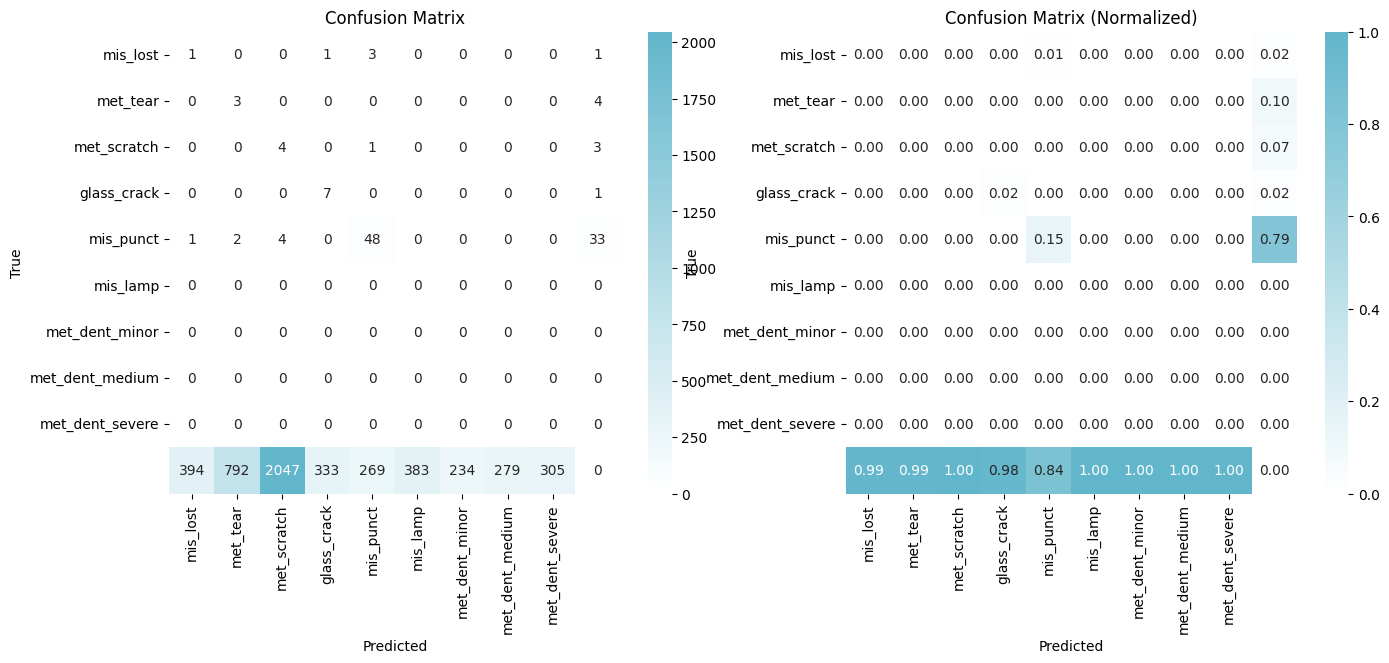

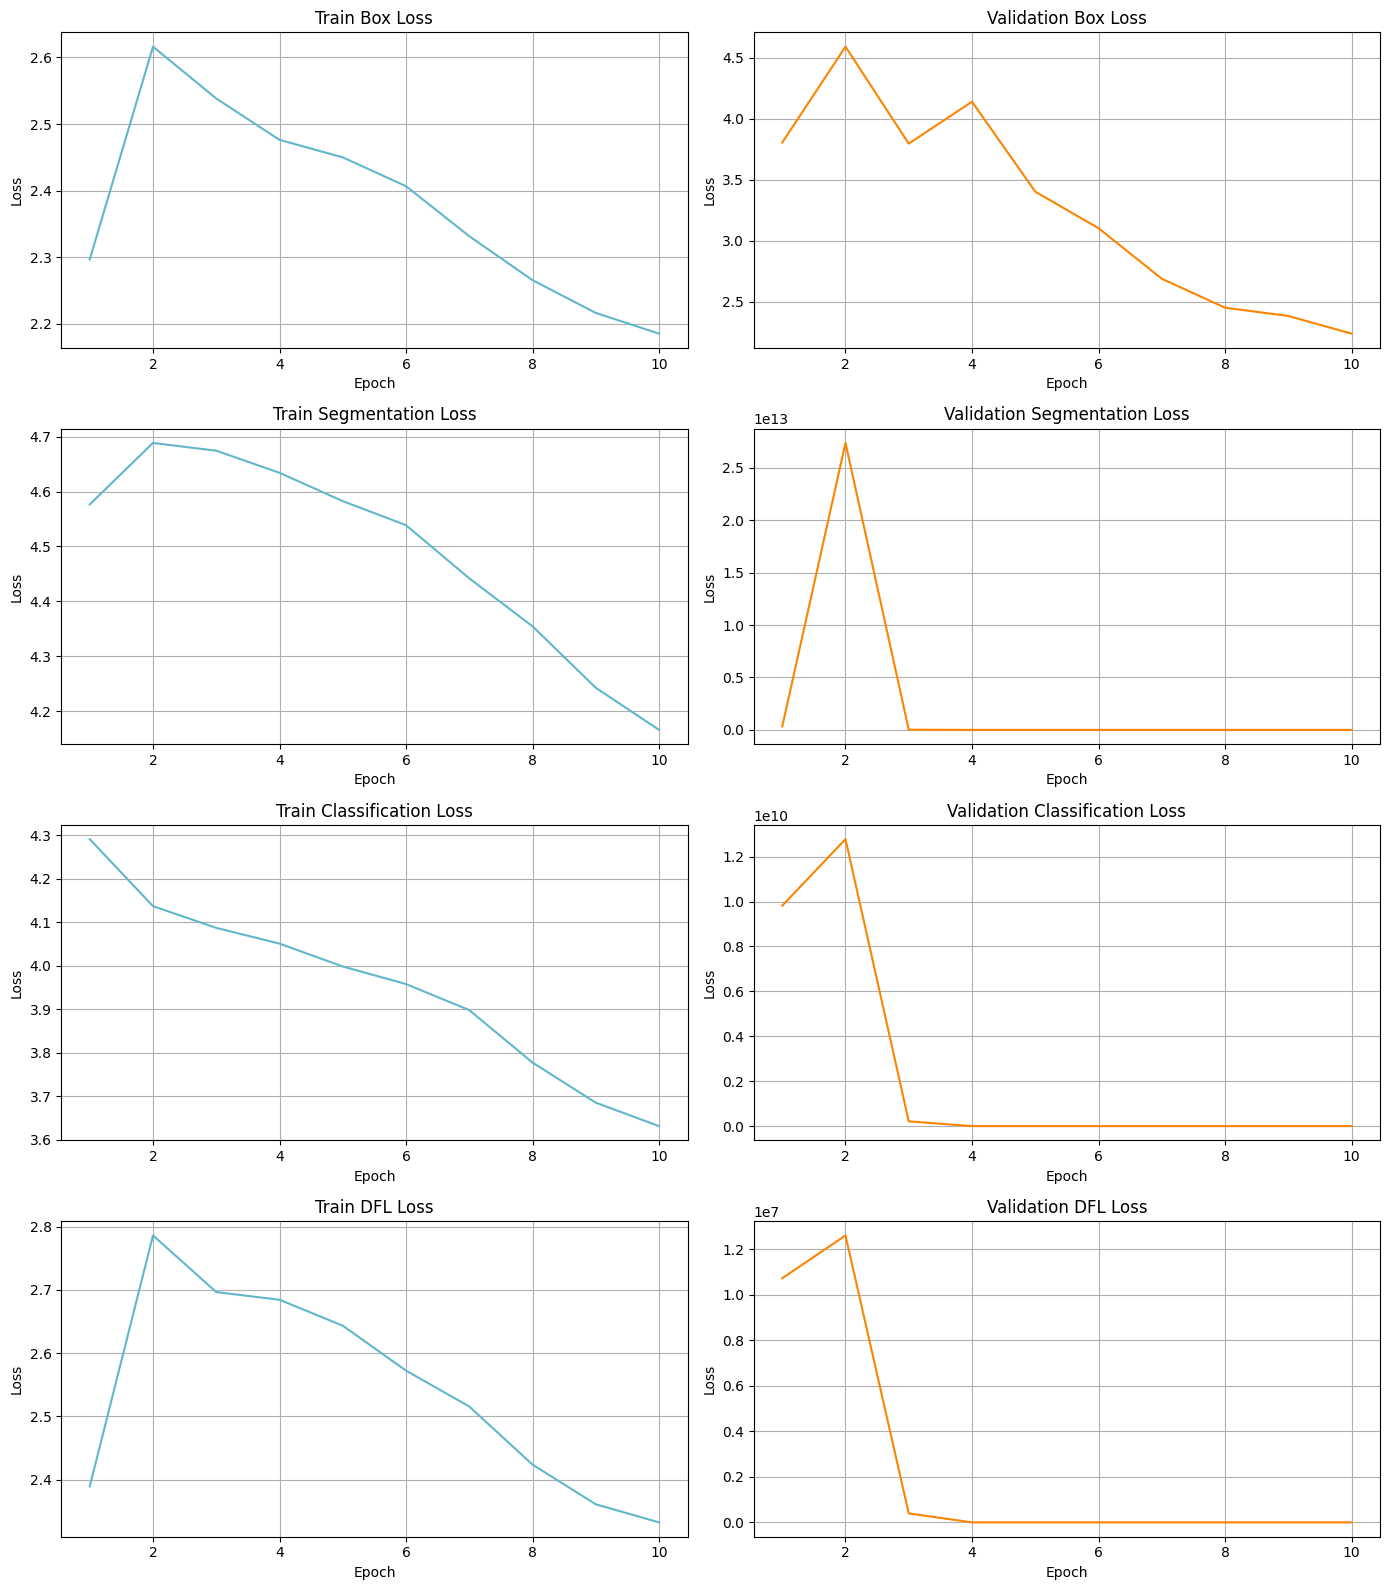

In [28]:
%matplotlib inline
# Validate the model
metrics_yolo(model = yolo_model,path_results_yolo = "./Models/runs/train", color1 = color1, color2 = color2)


# Tuning

In [ ]:
from sklearn.model_selection import ParameterGrid
import os

# Define hyperparameters to tune
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [32, 64, 128]
optimizers = ['adam', 'sgd']
epochs = [50, 100, 150]
network_architectures = ['yolov8', 'yolov8-tiny']
activation_functions = ['relu', 'leaky_relu']
loss_functions = ['binary_crossentropy', 'focal_loss']
data_augmentation = [True, False]

# Set up the search space
search_space = {'learning_rate': learning_rates,
                'batch_size': batch_sizes,
                'optimizer': optimizers,
                'epochs': epochs,
                'network_architecture': network_architectures,
                'activation_function': activation_functions,
                'loss_function': loss_functions,
                'data_augmentation': data_augmentation}

# Create parameter grid
parameter_grid = ParameterGrid(search_space)

# Train and evaluate the model for each combination of hyperparameters
for parameters in parameter_grid:
    # Set hyperparameters for the model
    learning_rate = parameters['learning_rate']
    batch_size = parameters['batch_size']
    optimizer = parameters['optimizer']
    num_epochs = parameters['epochs']
    architecture = parameters['network_architecture']
    activation = parameters['activation_function']
    loss = parameters['loss_function']
    augmentation = parameters['data_augmentation']
    
    # Train and evaluate the model
    train_yolo_v8(learning_rate, batch_size, optimizer, num_epochs, architecture, activation, loss, augmentation)
    mAP = evaluate_yolo_v8()
    
    # Save the results
    result = {'learning_rate': learning_rate,
              'batch_size': batch_size,
              'optimizer': optimizer,
              'num_epochs': num_epochs,

In [11]:
with open('./Notebooks/data.yaml', 'r') as file:
    data = yaml.safe_load(file)

# Obtener la ruta de entrenamiento
train_path = data['train']

number_img =len(os.listdir(train_path))

20

In [6]:
space = {
    'lr0': [0.001, 0.01],  # Initial learning rate
    'weight_decay': [0.0, 0.001, 0.01, 0.1],
    'batch': [ 128, 256, number_img*0.01 , number_img*0.1],
    'patience': 20,
    'epochs': [100, 200, 250],
    'dropout': [0.0, 0.1, 0.2]
}

# Tune the model
# yolo_model = YOLO(os.path.join(weights_yolo_path, "yolov8m-seg.pt"))
# yolo_model.tune(space=space, data='./Notebooks/data.yaml', epochs =1, iterations = 3 )

Tuner: Initialized Tuner instance with 'tune_dir=C:\Users\teres\OneDrive\Documentos\UCD\Summer\project-danielteresa\runs\segment\tune12'
Tuner:  Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/3 with hyperparameters: {'lr0': 0.01, 'weight_decay': 0.0005}
Saved C:\Users\teres\OneDrive\Documentos\UCD\Summer\project-danielteresa\runs\segment\tune12\tune_scatter_plots.png
Saved C:\Users\teres\OneDrive\Documentos\UCD\Summer\project-danielteresa\runs\segment\tune12\tune_fitness.png

Tuner: 1/3 iterations complete  (180.61s)
Tuner: Results saved to C:\Users\teres\OneDrive\Documentos\UCD\Summer\project-danielteresa\runs\segment\tune12
Tuner: Best fitness=0.00158 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.33667, 'metrics/recall(B)': 0.00585, 'metrics/mAP50(B)': 0.00415, 'metrics/mAP50-95(B)': 0.00094, 'metrics/precision(M)': 0.33667, 'metrics/recall(M)': 0.00585, 'metrics/mAP50(M)': 0.00084, 'met

In [17]:
model.train(data="data.yaml", epochs=100, optimizer='Adam', task='segment')

# Path to save/load the model
model_path = "../Models/yolo_model.pkl"

# Fit the GLM with Gamma family and log link if it is not saved
if os.path.exists(model_path):
    print("Loading existing model...")
    yolo_model = joblib.load(model_path)
else:
    print("Training new model...")
    try:
        yolo_model = model.train(data="data.yaml", epochs=100, optimizer='Adam', task='segment')
        gb_model.fit(X_train, y_train)
        # Save the model
        joblib.dump(gb_model, model_path)
        print(f"Model saved to {model_path}")
    except Exception as e:
        print("Error fitting the model:", e)
        raise e

Tuner: Initialized Tuner instance with 'tune_dir=C:\Users\teres\OneDrive\Documentos\UCD\Summer\project-danielteresa\runs\segment\tune9'
Tuner:  Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/10 with hyperparameters: {'lr0': 0.01}


In [19]:
results = model.predict("03bda226ad62553c0c73.jpg")


image 1/1 c:\Users\teres\OneDrive\Documentos\UCD\Summer\project-danielteresa\03bda226ad62553c0c73.jpg: 480x640 300 met_scratchs, 501.6ms
Speed: 5.4ms preprocess, 501.6ms inference, 145.0ms postprocess per image at shape (1, 3, 480, 640)


In [34]:
results[0].masks

ultralytics.engine.results.Masks object with attributes:

data: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,

In [22]:
# Realizar predicciones
results = model.predict("03bda226ad62553c0c73.jpg", conf=0.9, iou=0.7)

# Visualizar resultados
for result in results:
    img = result.plot(show=True, labels=True, masks=True, boxes=True)
    plt.imshow(img)
    plt.show()


image 1/1 c:\Users\teres\OneDrive\Documentos\UCD\Summer\project-danielteresa\03bda226ad62553c0c73.jpg: 480x640 132 met_scratchs, 412.3ms
Speed: 0.0ms preprocess, 412.3ms inference, 58.0ms postprocess per image at shape (1, 3, 480, 640)


<Figure size 640x480 with 1 Axes>

In [ ]:
%%writefile train.py

import subprocess
import sys

# Install ultralytics
subprocess.check_call([sys.executable, "-m", "pip", "install", "ultralytics"])

import argparse
import sys
import os
import shutil
import torch
import random

from ultralytics import YOLO


def select_images(source_folder, destination_folder, num_images, images_folder, labels_folder, seed):
    random.seed(seed)
    # Delete the destination folder if it already exists
    print("inside the function")
    if os.path.exists(destination_folder):
        shutil.rmtree(destination_folder)
    
    # Create the full paths for the images and labels folders
    images_folder_path = os.path.join(source_folder, images_folder)
    labels_folder_path = os.path.join(source_folder, labels_folder)

    destination_images_folder = os.path.join(destination_folder, images_folder)
    destination_labels_folder = os.path.join(destination_folder, labels_folder)

    # Create the destination folders
    os.makedirs(destination_images_folder)
    os.makedirs(destination_labels_folder)

    # Get the list of images and select a random subset
    images = os.listdir(images_folder_path)
    selected_images = random.sample(images, num_images)

    # Copy the images and their corresponding labels
    for image in selected_images:
        image_name = os.path.splitext(image)[0]
        source_image_path = os.path.join(images_folder_path, image)
        destination_image_path = os.path.join(destination_images_folder, image)
        
        source_label_path = os.path.join(labels_folder_path, f"{image_name}.txt")
        destination_label_path = os.path.join(destination_labels_folder, f"{image_name}.txt")
        
        shutil.copy(source_image_path, destination_image_path)
        if os.path.exists(source_label_path):
            shutil.copy(source_label_path, destination_label_path)

if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    # Hyperparameters
    parser.add_argument("--num_images", type=int, default=50)
    parser.add_argument("--seed", type=int, default=123)
    
    parser.add_argument('--epochs',type=int, help='number of training epochs')
    parser.add_argument("--batch", type=int, default=5)
    
    parser.add_argument('--optimizer', type=str, help='optimizer to use')
    parser.add_argument('--lr0', type=float, help='initial learning rate')
    parser.add_argument('--lrf', type=float, help='final learning rate')
    parser.add_argument('--momentum', type=float, help='momentum')
    parser.add_argument('--weight_decay', type=float, help='optimizer weight decay')

    # SageMaker specific arguments
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--runs-path", type=str, default=os.environ.get("SM_OUTPUT_DATA_DIR"))

   
    args = parser.parse_args()

    print('---------------Debug injected environment and arguments--------------------')
    print(sys.argv)
    print(os.environ)
    print('---------------End debug----------------------')

    if not args.train:
        raise ValueError("The --train argument or SM_CHANNEL_TRAIN environment variable must be set.")
    
    # Folder setup
    train_folder = os.path.join(args.train, 'train')
    val_folder = os.path.join(args.train, 'val')
    
    actual_path = os.getcwd()
    print(actual_path)
    destination_train_folder = os.path.join(args.train, os.path.join(actual_path, 'train_prueba'))
    destination_val_folder = os.path.join(args.train, 'val_prueba')

    # Select images
    select_images(train_folder, destination_train_folder, args.num_images, 'images', 'labels', args.seed)
    select_images(val_folder, destination_val_folder, args.num_images, 'images', 'labels', args.seed)

    # Train the YOLO model
    # yolo_model = YOLO(os.path.join(args.weights_yolo_path, "yolov8m-seg.pt"))
    yolo_model = YOLO("yolov8m-seg.pt")
    yolo_model.train(data=os.path.join(args.train, "data.yaml"), 
                     batch=args.batch,
                     epochs=args.epochs, 
                     optimizer=args.optimizer, 
                     lr0=args.lr0, 
                     lrf=args.lrf, 
                     momentum=args.momentum,
                     weight_decay=args.weight_decay,
                     task='segment',
                     project=args.runs_path)
    
    yolo_model.export()

    # Save the YOLO model
    # model_path = os.path.join(args.model_dir, "yolo_model.pt")
    # torch.save(yolo_model.state_dict(), model_path)